In [1]:
import torch
import numpy as np
import polars as pl
import seaborn as sns
import gymnasium as gym
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from itertools import count
from dataclasses import dataclass

%load_ext autoreload
%autoreload 2
from comp_capacity.repr.network import ProgressiveRNN, Network, sample_network, Topology, VanillaRNN, NONLINEARITY_MAP

In [2]:
@dataclass
class EnvResults:
    reward: np.ndarray
    total_steps: np.ndarray
    naninf: np.ndarray
    matrices: Topology
    network_hash: str
    network: Network
    parameter_count: int
    input_dim: int
    output_dim: int
    seed: int

In [9]:
def run_multistep_env(matrices, env, seed, device) -> EnvResults:
    input_dim = env.observation_space.shape[-1]
    if isinstance(env.action_space, gym.spaces.Discrete):
        output_dim = env.action_space.n
    elif isinstance(env.action_space, gym.spaces.MultiDiscrete):
        output_dim = env.action_space.nvec[0]
    else:
        output_dim = env.action_space.shape[-1]
        
    # Create the network
    matrices_all = {
        "input": Topology(
            adjacency=torch.ones((input_dim, matrices.adjacency.shape[0]), device=device),
            nonlinearities=None,
        ),
        "recurrent": Topology(
            adjacency=matrices.adjacency,
            weights=matrices.weights,
            nonlinearities=None,
        ),
        "output": Topology(
            adjacency=torch.ones((matrices.adjacency.shape[0], output_dim), device=device),
            nonlinearities=None,
        ),
    }

    network = VanillaRNN(
        toplogies=[matrices_all[key] for key in ["input", "recurrent", "output"]],
        device=device,
    )
    
    # network = ProgressiveRNN(
    #     matrices=matrices,
    #     input_dim=input_dim,
    #     output_dim=output_dim,
    #     device=device,
    # )

    batch_size = env.num_envs

    done_vec = np.zeros(batch_size, dtype=bool)
    reward_vec = np.zeros(batch_size, dtype=float)
    total_steps = np.zeros(batch_size, dtype=int)
    naninf = np.zeros(batch_size, dtype=bool)

    obs, info = env.reset(seed=seed)

    state = None
    states = []
    for step in count(1):
        obs_tensor = torch.from_numpy(obs).to(device)
        out, state = network(obs_tensor, state)
        states.append(state.detach().clone().cpu().numpy())
        if torch.any(torch.isnan(out)) or torch.any(torch.isnan(state)):
            # consider it terminated
            naninf |= np.logical_or(
                (~np.isfinite(out.detach().cpu())).any(-1),
                (~np.isfinite(state.detach().cpu())).any(-1),
            )
            done_vec |= naninf

            mask = ~torch.isfinite(out)
            out[mask] = 0.0

        if isinstance(
            env.action_space, (gym.spaces.Discrete, gym.spaces.MultiDiscrete)
        ):
            action = torch.distributions.Categorical(logits=out).sample()
        else:
            action = out

        obs, reward, terminated, truncated, info = env.step(action.cpu().numpy())

        done_vec |= np.logical_or(terminated, truncated)
        reward_vec += reward * (1 - done_vec)
        total_steps += 1 * (1 - done_vec)

        if done_vec.all():
            break

    return EnvResults(
        reward=reward_vec,
        total_steps=total_steps,
        network_hash=matrices.generate_hash(),
        parameter_count=sum(p.numel() for p in network.parameters()),
        input_dim=input_dim,
        output_dim=output_dim,
        seed=seed,
        matrices=matrices,
        network=network,
        naninf=naninf,
    )

In [10]:
def aggregate_results(
    results: EnvResults,
    num_envs: int,
    env_name: str,
    nodes: int,
    resample: int,
    recurrent: bool,
):
    output = []
    for i in range(num_envs):
        output.append(
            {
                "reward": results.reward[i],
                "total_steps": results.total_steps[i],
                "id": results.network_hash,
                "parameter_count": results.parameter_count,
                "input_dim": results.input_dim,
                "output_dim": results.output_dim,
                "naninf": results.naninf[i],
                "seed": results.seed,
                "batch": i,
                "env": env_name,
                "nodes": nodes,
                "resample": resample,
                "recurrent": recurrent,
                "n_recurrent_edges": torch.tril(results.matrices.adjacency).sum().item(),
            }
        )
    return output

In [11]:
num_envs = 10
env_name = "CartPole-v1"
env = gym.make_vec(env_name, num_envs=num_envs, vectorization_mode="async")

device = torch.device("cpu")
recurrent = True
n_samples = 3000
num_resamples = 5
connection_prob = 0.3

node_increment_prob = 1 / 50

torch.manual_seed(0)
n_nodes = torch.cumsum(torch.rand(n_samples) < node_increment_prob, dim=0) + 2

df_items = []
matrix_store = {}
pbar = tqdm(range(n_samples))
for seed in pbar:

    nodes = int(n_nodes[seed].item())
    matrices = sample_network(
        n_nodes=nodes,
        connection_prob=connection_prob,
        device=device,
        recurrent=recurrent,
    )
    _hash = matrices.generate_hash()
    if _hash in matrix_store:
        continue

    for r in range(num_resamples):
        results = run_multistep_env(
            matrices=matrices,
            env=env,
            seed=seed,
            device=device,
        )
        df_items.extend(
            aggregate_results(
                results=results,
                num_envs=num_envs,
                env_name=env_name,
                nodes=nodes,
                resample=r,
                recurrent=recurrent,
            )
        )
    matrix_store[results.network_hash] = matrices
    pbar.set_description(f"Current node count: {nodes}")

  0%|          | 0/3000 [00:00<?, ?it/s]

/Users/richardhakim/Documents/github_repos/computational-capacity/.venv/lib/python3.12/site-packages/gymnasium/vector/async_vector_env.py:457: UserWarning: ERROR: Received the following error from Worker-5 - Shutting it down
  self._raise_if_errors(successes)
/Users/richardhakim/Documents/github_repos/computational-capacity/.venv/lib/python3.12/site-packages/gymnasium/vector/async_vector_env.py:457: UserWarning: ERROR: Traceback (most recent call last):
  File "/Users/richardhakim/Documents/github_repos/computational-capacity/.venv/lib/python3.12/site-packages/gymnasium/vector/async_vector_env.py", line 763, in _async_worker
    ) = env.step(data)
        ^^^^^^^^^^^^^^
  File "/Users/richardhakim/Documents/github_repos/computational-capacity/.venv/lib/python3.12/site-packages/gymnasium/wrappers/common.py", line 125, in step
    observation, reward, terminated, truncated, info = self.env.step(action)
                                                       ^^^^^^^^^^^^^^^^^^^^^
  File "/

AssertionError: np.int64(2) (<class 'numpy.int64'>) invalid

In [ ]:
df = pl.DataFrame(df_items).with_columns(pl.col("naninf").cast(pl.Boolean))

In [ ]:
len(df)

6770

In [ ]:
df.head()

reward,total_steps,id,parameter_count,input_dim,output_dim,naninf,seed,batch,env,nodes,resample,recurrent,n_recurrent_edges
f64,i64,str,i64,i64,i64,bool,i64,i64,str,i64,i64,bool,i64
11.0,11,"""15ff79436664c3128b9d11a5625a7f…",13,4,2,false,0,0,"""CartPole-v1""",2,0,true,1
27.0,27,"""15ff79436664c3128b9d11a5625a7f…",13,4,2,false,0,1,"""CartPole-v1""",2,0,true,1
21.0,21,"""15ff79436664c3128b9d11a5625a7f…",13,4,2,false,0,2,"""CartPole-v1""",2,0,true,1
13.0,13,"""15ff79436664c3128b9d11a5625a7f…",13,4,2,false,0,3,"""CartPole-v1""",2,0,true,1
23.0,23,"""15ff79436664c3128b9d11a5625a7f…",13,4,2,false,0,4,"""CartPole-v1""",2,0,true,1


In [ ]:
df.head()

reward,total_steps,id,parameter_count,input_dim,output_dim,naninf,seed,batch,env,nodes,resample,recurrent,n_recurrent_edges
f64,i64,str,i64,i64,i64,bool,i64,i64,str,i64,i64,bool,i64
11.0,11,"""2d99aab2c4acbdf6""",13,4,2,false,0,0,"""CartPole-v1""",2,0,true,1
27.0,27,"""2d99aab2c4acbdf6""",13,4,2,false,0,1,"""CartPole-v1""",2,0,true,1
60.0,60,"""2d99aab2c4acbdf6""",13,4,2,false,0,2,"""CartPole-v1""",2,0,true,1
13.0,13,"""2d99aab2c4acbdf6""",13,4,2,false,0,3,"""CartPole-v1""",2,0,true,1
23.0,23,"""2d99aab2c4acbdf6""",13,4,2,false,0,4,"""CartPole-v1""",2,0,true,1


In [ ]:
avg = (
    df.filter(~pl.col("naninf")).group_by(["seed", "batch"])
    .agg(pl.col(["reward", "nodes", "parameter_count", "n_recurrent_edges"]).mean())
    .sort("reward", descending=True)
)

In [ ]:
avg.head()

seed,batch,reward,nodes,parameter_count,n_recurrent_edges
i64,i64,f64,f64,f64,f64
40,6,42.0,2.0,14.0,1.0
135,0,41.5,4.0,35.0,3.0
126,0,41.2,4.0,30.0,2.0
126,6,40.8,4.0,30.0,2.0
45,4,40.0,2.0,19.0,1.0


<Axes: >

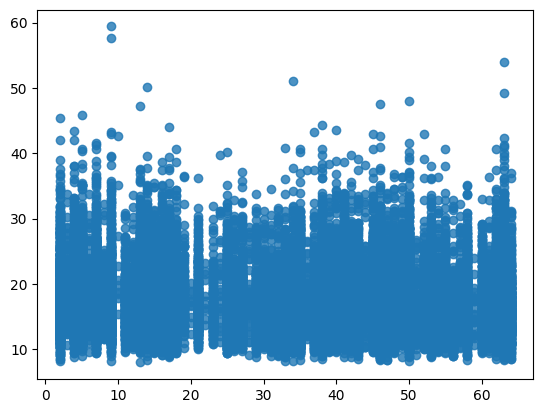

In [ ]:
sns.regplot(
    # data=avg.group_by("nodes").agg(pl.col("reward").mean()),
    data=avg,
    x="nodes",
    y="reward",
)

<Axes: >

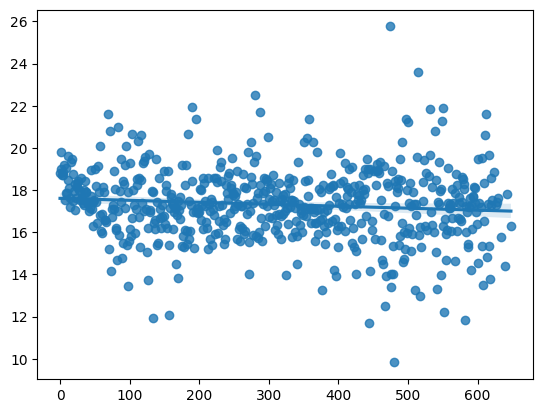

In [ ]:
sns.regplot(
    data=avg.group_by("n_recurrent_edges").agg(pl.col("reward").mean()),
    x="n_recurrent_edges",
    y="reward",
)

<Axes: >

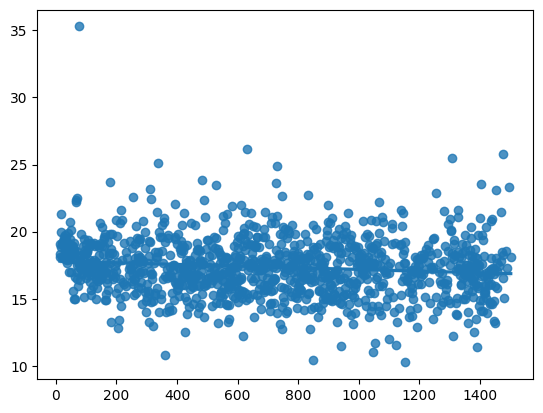

In [ ]:
sns.regplot(
    data=avg.group_by("parameter_count").agg(pl.col("reward").mean()),
    x="parameter_count",
    y="reward",
)

In [ ]:
aligned_matrices = align_connectivity_matrices(matrix_store)

In [ ]:
import umap

In [ ]:
aligned_matrices = {k: v.concat()[0].numpy().flatten() for k, v in aligned_matrices.items()}
shape = len(aligned_matrices[list(aligned_matrices)[0]])

In [ ]:
rewards = df.filter(~pl.col("naninf")).group_by("id").agg(pl.col(["reward", "nodes"]).median())

In [ ]:
# turn matrix into array
mtx_df = pl.DataFrame(
    [{"id": k, "matrix": v.tolist()} for k, v in aligned_matrices.items()],
    schema={"id": pl.String, "matrix": pl.Array(pl.Boolean, shape)},
)

In [ ]:
merged = rewards.join(mtx_df, on="id", how="inner")

In [ ]:
merged.head()

id,reward,nodes,matrix
str,f64,f64,"array[bool, 4884]"
"""15ff79436664c3128b9d11a5625a7f…",16.0,2.0,"[false, false, … false]"
"""02a8d02bec2f42d37f887c79d5e664…",15.0,2.0,"[false, true, … false]"
"""4eec5685e6f8edcf907e0bf3bf1761…",12.5,2.0,"[false, false, … false]"
"""6881060b160f3e8ba58d047ff16686…",14.0,2.0,"[false, true, … false]"
"""31cc3189bbb578638b648e1e39a2c6…",17.0,2.0,"[false, true, … false]"


In [ ]:
mdl = umap.UMAP(
    n_neighbors=15,
    n_components=2,
    metric="jaccard",
)

embedding = mdl.fit_transform(
    merged["matrix"].to_numpy()
)

/home/wingillis/dev/computational-capacity/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/wingillis/dev/computational-capacity/.venv/lib/python3.12/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


In [ ]:
embedding_df = pl.DataFrame(
    {
        "x": embedding[:, 0],
        "y": embedding[:, 1],
        "id": merged["id"].to_numpy(),
    }
)

embedding_df = embedding_df.join(
    merged,
    on="id",
    how="inner",
).drop("matrix")

<Axes: xlabel='x', ylabel='y'>

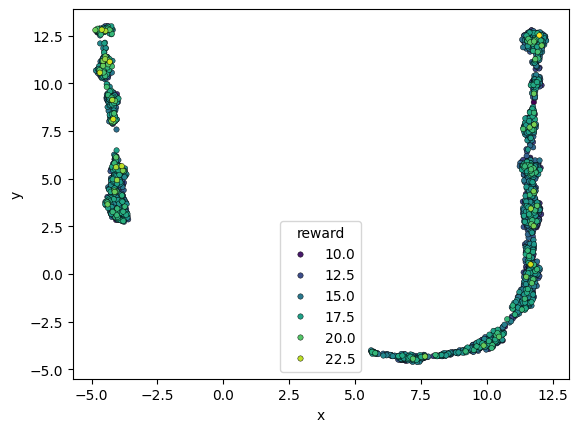

In [ ]:
sns.scatterplot(
    data=embedding_df.sort("reward", descending=False),
    x="x",
    y="y",
    hue="reward",
    palette="viridis",
    s=15,
    edgecolor="black",
)

<Axes: xlabel='x', ylabel='y'>

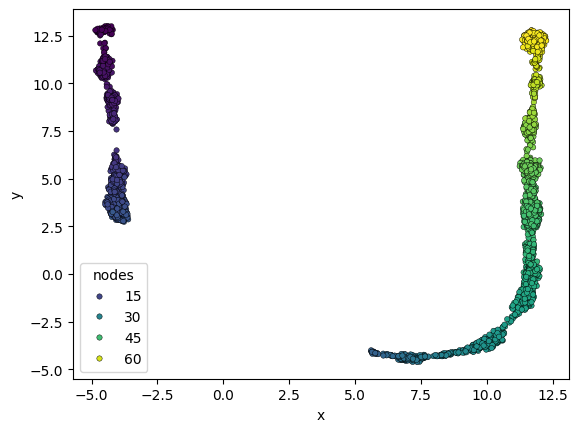

In [ ]:
sns.scatterplot(
    data=embedding_df.sort("reward", descending=False),
    x="x",
    y="y",
    hue="nodes",
    palette="viridis",
    s=15,
    edgecolor="black",
)